In [1]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
plt.style.use('ggplot')

In [3]:
# 設定 data_path
data_path = './'
# data_path = 'D:/Coding Project/GitHub/ML100-Days/data/Kaggle/Midterm exam for ML 100 marathon by Cupoy/'
df_submission = pd.read_csv(data_path + 'sample_submission.csv', header = 'infer')
df_train = pd.read_csv(data_path + 'train_data.csv', header = 'infer', index_col = "name")
df_test = pd.read_csv(data_path + 'test_features.csv', header = 'infer', index_col = "name")
print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)
print('Sample_submission shape:', df_submission.shape)

Train shape: (113, 21)
Test shape: (33, 20)
Sample_submission shape: (33, 2)


In [4]:
payment_data = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments']
stock_data = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
email_data = ['to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi'] 
features_list = ['poi'] + payment_data + stock_data + email_data              

In [5]:
df_data  = pd.concat([df_train, df_test])
df_data = df_data.replace('NaN', np.nan)
df_data = df_data[features_list]
print('df_data shape:', df_data.shape)

df_data shape: (146, 20)


### Outlier Investigation and Data Cleaning

In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, RICE KENNETH D to MCMAHON JEFFREY
Data columns (total 20 columns):
poi                          113 non-null object
salary                       95 non-null float64
bonus                        82 non-null float64
long_term_incentive          66 non-null float64
deferred_income              49 non-null float64
deferral_payments            39 non-null float64
loan_advances                4 non-null float64
other                        93 non-null float64
expenses                     95 non-null float64
director_fees                17 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
to_messages                  86 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-nul

In [7]:
df_data.describe()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
count,9.500000e+01,8.200000e+01,6.600000e+01,4.900000e+01,3.900000e+01,4.000000e+00,9.300000e+01,9.500000e+01,1.700000e+01,1.250000e+02,1.020000e+02,1.100000e+02,1.800000e+01,1.260000e+02,86.000000,86.000000,86.000000,86.000000,86.000000
mean,5.621943e+05,2.374235e+06,1.470361e+06,-1.140475e+06,1.642674e+06,4.196250e+07,9.190650e+05,1.087289e+05,1.668049e+05,5.081526e+06,5.987054e+06,2.321741e+06,1.664106e+05,6.773957e+06,2073.860465,608.790698,64.895349,41.232558,1176.465116
std,2.716369e+06,1.071333e+07,5.942759e+06,4.025406e+06,5.161930e+06,4.708321e+07,4.589253e+06,5.335348e+05,3.198914e+05,2.906172e+07,3.106201e+07,1.251828e+07,4.201494e+06,3.895777e+07,2582.700981,1841.033949,86.979244,100.073111,1178.317641
min,4.770000e+02,7.000000e+04,6.922300e+04,-2.799289e+07,-1.025000e+05,4.000000e+05,2.000000e+00,1.480000e+02,3.285000e+03,1.480000e+02,3.285000e+03,-2.604490e+06,-7.576788e+06,-4.409300e+04,57.000000,12.000000,0.000000,0.000000,2.000000
25%,2.118160e+05,4.312500e+05,2.812500e+05,-6.948620e+05,8.157300e+04,1.600000e+06,1.215000e+03,2.261400e+04,9.878400e+04,3.944750e+05,5.278862e+05,2.540180e+05,-3.896218e+05,4.945102e+05,541.250000,22.750000,10.000000,1.000000,249.750000
50%,2.599960e+05,7.693750e+05,4.420350e+05,-1.597920e+05,2.274490e+05,4.176250e+07,5.238200e+04,4.695000e+04,1.085790e+05,1.101393e+06,1.310814e+06,4.517400e+05,-1.469750e+05,1.102872e+06,1211.000000,41.000000,35.000000,8.000000,740.500000
75%,3.121170e+05,1.200000e+06,9.386720e+05,-3.834600e+04,1.002672e+06,8.212500e+07,3.620960e+05,7.995250e+04,1.137840e+05,2.093263e+06,2.547724e+06,1.002370e+06,-7.500975e+04,2.949847e+06,2634.750000,145.500000,72.250000,24.750000,1888.250000
max,2.670423e+07,9.734362e+07,4.852193e+07,-8.330000e+02,3.208340e+07,8.392500e+07,4.266759e+07,5.235198e+06,1.398517e+06,3.098866e+08,3.117640e+08,1.303223e+08,1.545629e+07,4.345095e+08,15149.000000,14368.000000,528.000000,609.000000,5521.000000


''' According to the official pdf documentation for the financial (payment and stock) data,
    values of NaN represent 0 and not unknown quantities.
    However, for the email data, NaNs are unknown information. '''

In [8]:
from sklearn.preprocessing import Imputer

# Fill in the NaN payment and stock values with 0 
df_train[payment_data] = df_train[payment_data].fillna(0)
df_train[stock_data] = df_train[stock_data].fillna(0)
df_test[payment_data] = df_test[payment_data].fillna(0)
df_test[stock_data] = df_test[stock_data].fillna(0)

# Fill in the NaN email data with the mean of column grouped by poi / non_poi
imp = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)

df_poi = df_train[df_train['poi'] == True];
df_nonpoi = df_train[df_train['poi'] == False]

df_poi.ix[:, email_data] = imp.fit_transform(df_poi.ix[:, email_data]);
df_nonpoi.ix[:, email_data] = imp.fit_transform(df_nonpoi.ix[:, email_data]);

# Fill in the NaN email data with the mean of column
for col in df_test[email_data].columns:
    mean = df_test[col].mean()    
    df_test[col] = np.where(df_test[col].isnull(), mean, df_test[col])

df_train = df_poi.append(df_nonpoi)
df_data  = pd.concat([df_train, df_test])
df_data = df_data[features_list]

In [9]:
# df[:-1] means to read from beginning to the end 
# The errors appear to be caused by a misalignment of the columns
errors = (df_data[df_data[payment_data[:-1]].sum(axis = 'columns') != df_data['total_payments']])
errors

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
name,,,,,,,,,,,,,,,,,,,,
BELFER ROBERT,False,0.0,0.0,0.0,0.0,-102500.0,0.0,0.0,0.0,3285.0,102500.0,3285.0,0.0,44093.0,-44093.0,2181.839286,815.928571,60.125,43.517857,1055.5
BHATNAGAR SANJAY,NaN,0.0,0.0,0.0,0.0,0.0,0.0,137864.0,0.0,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,523.000000,29.000000,0.000,1.000000,463.0


In [10]:
# Retrieve the incorrect data for Belfer
Belfer_financial = df_data.ix['BELFER ROBERT', 1:len(payment_data + stock_data) + 1].tolist()

# Delete the first element to shift left and add on a 0 to end as indicated in financial data
Belfer_financial.pop(0) # remove first value
Belfer_financial.append(0) # add on a 0 to end

# Reinsert corrected data
df_data.ix['BELFER ROBERT', 1 : len(payment_data + stock_data) + 1] = Belfer_financial
# -------------------------------------------------------------------------------------- #
# Retrieve the incorrect data for Bhatnagar
Bhatnagar_financial = df_data.ix['BHATNAGAR SANJAY', 1:len(payment_data + stock_data) + 1].tolist()

# Delete the last element to shift right and add on a 0 to beginning
Bhatnagar_financial.pop(-1) # remove last value
Bhatnagar_financial = [0] + Bhatnagar_financial # add on a 0 to front

# Reinsert corrected data
df_data.ix['BHATNAGAR SANJAY', 1:len(payment_data + stock_data) + 1] = Bhatnagar_financial

In [11]:
# Check for any more errors with the payment data
len(df_data[df_data[payment_data[:-1]].sum(axis = 'columns') != df_data['total_payments']])

0

In [12]:
# Check for any errors with the stock data
len(df_data[df_data[stock_data[:-1]].sum(axis = 'columns') != df_data['total_stock_value']])

0

* InterquartileRrange (IQR)：The difference (upper quartile Q3 - lower quartile Q1) is called the interquartile range.
* Box plots with fences
 1. lower inner fence: Q1 - 1.5 * IQR
 2. upper inner fence: Q3 + 1.5 * IQR
 3. lower outer fence: Q1 - 3 * IQR
 4. upper outer fence: Q3 + 3 * IQR

* Outlier detection criteria	A point beyond an inner fence on either side is considered a mild outlier. A point beyond an outer fence is considered an extreme outlier.
The [official definition of a mild outlier](http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm) is either below the (first quartile  minus 1.5 times the Interquartile Range (IQR))  or  above the (third quartile plus 1.5 times the IQR):
$$ low\ outlier < first\ quartile - 1.5\ x\ IQR $$
$$ high\ outlier > third\ quartile + 1.5\ x\ IQR $$

Remove 'TOTAL' because it is currently the last row of the dataframe and it will throw off any predictions, and 'THE TRAVEL AGENCY IN THE PARK', which a was a company co-owned by Enron's former Chairman's sister and is clearly not an individual that should be included in the dataset.

In [13]:
df_data.loc[['TOTAL', 'THE TRAVEL AGENCY IN THE PARK']]
# df_data.drop(axis = 0, labels = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK'], inplace = True)

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
name,,,,,,,,,,,,,,,,,,,,
TOTAL,NaN,26704229.0,97343619.0,48521928.0,-27992891.0,32083396.0,83925000.0,42667589.0,5235198.0,1398517.0,309886585.0,311764000.0,130322299.0,-7576788.0,434509511.0,1819.428571,291.428571,65.190476,44.761905,1377.952381
THE TRAVEL AGENCY IN THE PARK,False,0.0,0.0,0.0,0.0,0.0,0.0,362096.0,0.0,0.0,362096.0,0.0,0.0,0.0,0.0,2181.839286,815.928571,60.125000,43.517857,1055.500000


In [14]:
IQR = df_data.quantile(q = 0.75) - df_data.quantile(q = 0.25)
first_quartile = df_data.quantile(q = 0.25) # Q1
third_quartile = df_data.quantile(q = 0.75) # Q3
outliers = df_data[(df_data > (third_quartile + 1.5 * IQR) ) | (df_data < (first_quartile - 1.5 * IQR) )].count(axis = 1)
outliers.sort_values(axis = 0, ascending = False, inplace = True)
outliers.head(12)

name
TOTAL                 14
LAY KENNETH L         12
FREVERT MARK A        12
BAXTER JOHN C          8
BELDEN TIMOTHY N       8
LAVORATO JOHN J        8
KEAN STEVEN J          7
SKILLING JEFFREY K     7
WHALLEY LAWRENCE G     7
KITCHEN LOUISE         5
HAEDICKE MARK E        5
BECK SALLY W           5
dtype: int64

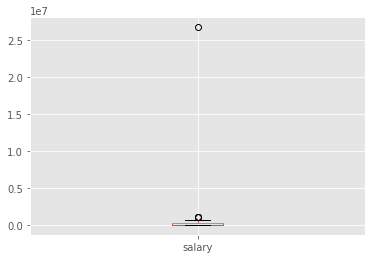

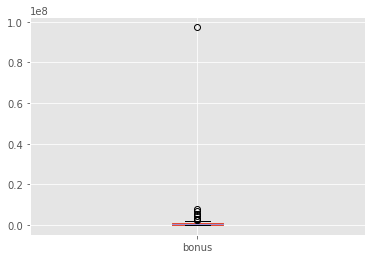

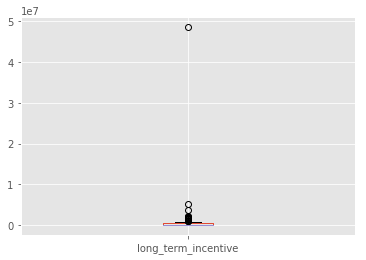

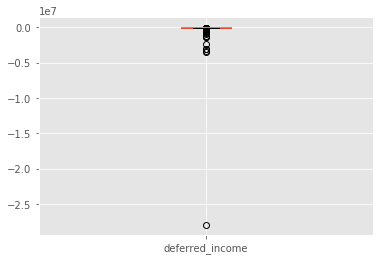

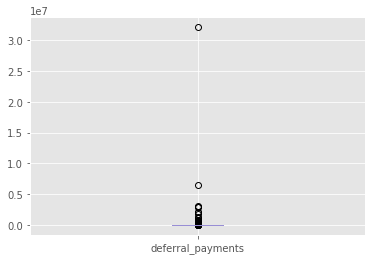

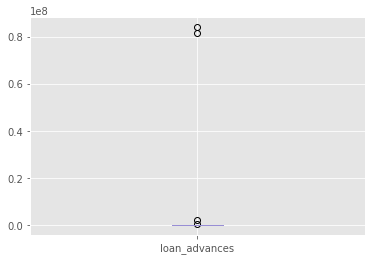

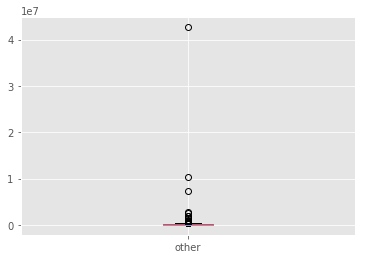

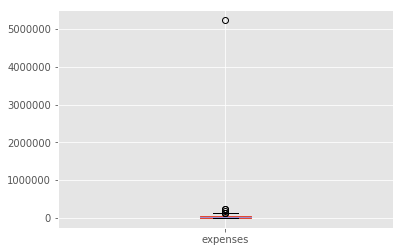

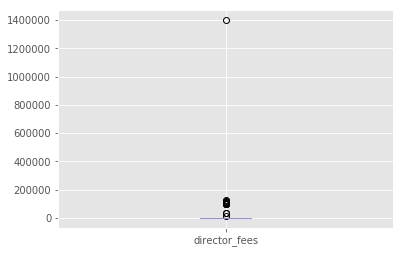

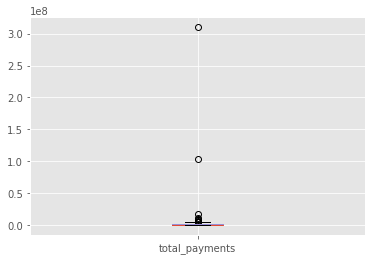

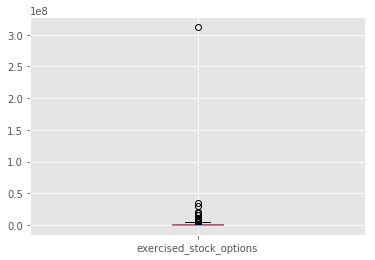

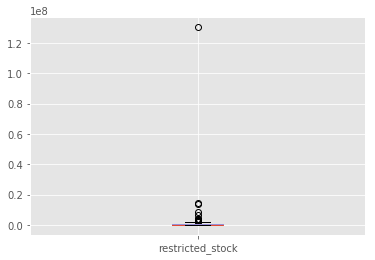

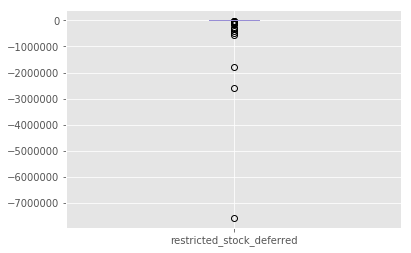

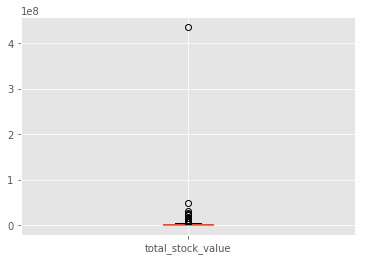

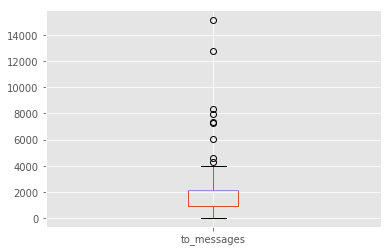

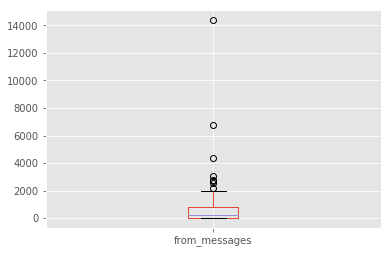

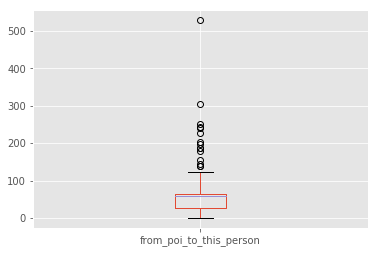

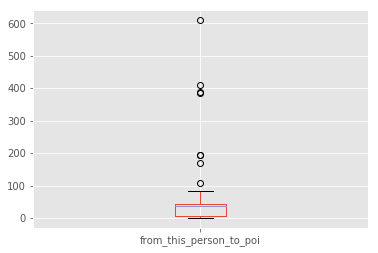

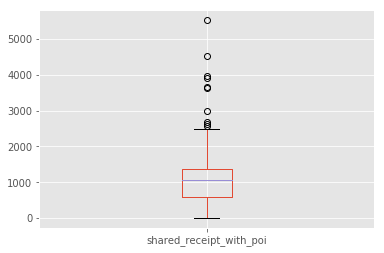

In [15]:
# 檢視這些欄位的數值範圍
for dtype, col in zip(df_data.dtypes, df_data.columns):
    if dtype == 'float64':
        df_data.boxplot(col)    
        plt.show()   

#### An outlier for a person of interest could be a sign of fradulent activity
【__Remain__】
1. Kenneth Lay, the CEO of Enron from 1986-2001, presided over many of the __illegal business activites__ and hence is one of 【the most vital persons of interest】.
2. Timothy Belden was the former head of trading for Enron who __developed the strategy to illegally raise energy prices__ in California.
3. Jeffrey Skilling replaced Kenneth Lay as CEO of Enron in 2001 and __orchestrated much of the fraud__ that destroyed Enron.

【__Remove__】
1. Mark Frevert served as chief executive of Enron Europe from 1986-2000 and was appointed as chairman of Enron in 2001. He was a major player in the firm, although not a person of interest. I believe that he is not representative of the average employee at Enron during this time because of his substantial compensation.
2. John Baxter was a former vice Enron vice chairman and died of an apparent self-inflicted gunshot before he was able to testify against other Enron executives.
3. John Lavorato was a top executive in the energy-trading branch of Enron and received large bonuses to keep him from leaving Enron. As he was not a person of interest, and the large bonus ended up skewing his total pay.
4. Lawrence Whalley served as the president of Enron and fired Andrew Fastow once it was apparent the severity of Enron's situation. He was investigated thoroughly but not identified as a person of interest.

In [16]:
df_data.loc[['LAY KENNETH L', 'FREVERT MARK A', 'BELDEN TIMOTHY N', 'SKILLING JEFFREY K', 'BAXTER JOHN C', 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G']]
# Remove the outlier individuals
# df_data.drop(axis = 0, labels = ['FREVERT MARK A', 'BAXTER JOHN C', 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G'], inplace = True)

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
name,,,,,,,,,,,,,,,,,,,,
LAY KENNETH L,True,1072321.0,7000000.0,3600000.0,-300000.0,202911.0,81525000.0,10359729.0,99832.0,0.0,103559793.0,34348384.0,14761694.0,0.0,49110078.0,4273.000000,36.000000,123.000,16.000000,2411.0
FREVERT MARK A,NaN,1060932.0,2000000.0,1617011.0,-3367011.0,6426990.0,2000000.0,7427621.0,86987.0,0.0,17252530.0,10433518.0,4188667.0,0.0,14622185.0,3275.000000,21.000000,242.000,6.000000,2979.0
BELDEN TIMOTHY N,NaN,213999.0,5249999.0,0.0,-2334434.0,2144013.0,0.0,210698.0,17355.0,0.0,5501630.0,953136.0,157569.0,0.0,1110705.0,7991.000000,484.000000,228.000,108.000000,5521.0
SKILLING JEFFREY K,True,1111258.0,5600000.0,1920000.0,0.0,0.0,0.0,22122.0,29336.0,0.0,8682716.0,19250000.0,6843672.0,0.0,26093672.0,3627.000000,108.000000,88.000,30.000000,2042.0
BAXTER JOHN C,False,267102.0,1200000.0,1586055.0,-1386055.0,1295738.0,0.0,2660303.0,11200.0,0.0,5634343.0,6680544.0,3942714.0,0.0,10623258.0,2181.839286,815.928571,60.125,43.517857,1055.5
LAVORATO JOHN J,False,339288.0,8000000.0,2035380.0,0.0,0.0,0.0,1552.0,49537.0,0.0,10425757.0,4158995.0,1008149.0,0.0,5167144.0,7259.000000,2585.000000,528.000,411.000000,3962.0
WHALLEY LAWRENCE G,False,510364.0,3000000.0,808346.0,0.0,0.0,0.0,301026.0,57838.0,0.0,4677574.0,3282960.0,2796177.0,0.0,6079137.0,6019.000000,556.000000,186.000,24.000000,3920.0


In [17]:
# Replacing outlier values with mean [> Q3 + 1.5 * IQR, < Q1 - 1.5 * IQR]
''' Method 1:
    median = df.loc[df['Age']<75, 'Age'].median()
    df.loc[df.Age > 75, 'Age'] = np.nan
    df.fillna(median,inplace=True) '''
''' Method 2:
    median = df.loc[df['Age']<75, 'Age'].median()
    df["Age"] = np.where(df["Age"] >75, median,df['Age'])'''
''' Method 3:
    median = df.loc[df['Age']<75, 'Age'].median()
    df["Age"] = df["Age"].mask(df["Age"] >75, median)'''

for dtype, col in zip(df_data.dtypes, df_data.columns):
    if dtype == 'float64':
        if (third_quartile[col] != 0.0) | (first_quartile[col] != 0.0):
            mean = df_data.loc[(df_data[col] <= (third_quartile[col]+1.5*IQR[col])) & (df_data[col] >= (first_quartile[col]-1.5*IQR[col])), col].mean()
            outlier = ((df_data[col] > (third_quartile[col]+1.5*IQR[col])) | (df_data[col] < (first_quartile[col]-1.5*IQR[col])))
            df_data[col] = np.where(outlier, mean, df_data[col])

C:\Users\10708055\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\10708055\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\10708055\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\10708055\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'norm

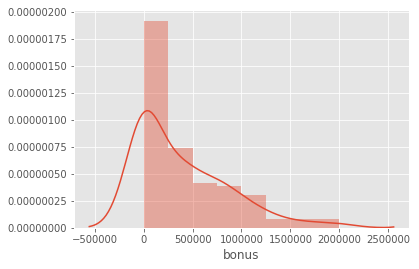

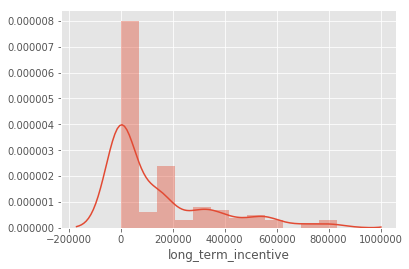

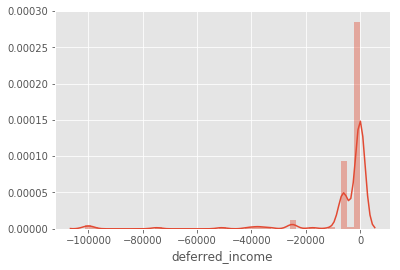

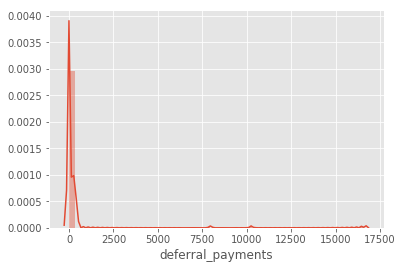

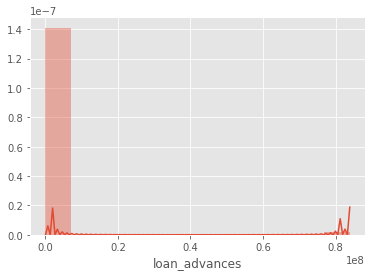

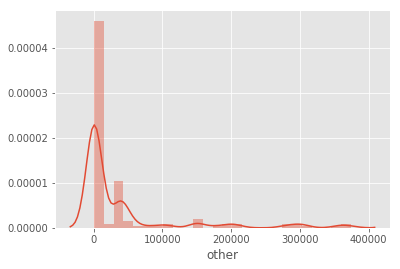

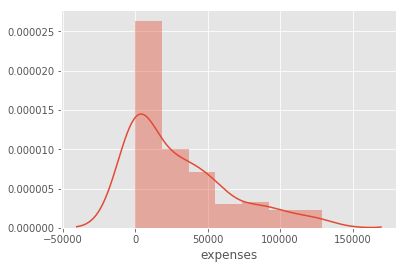

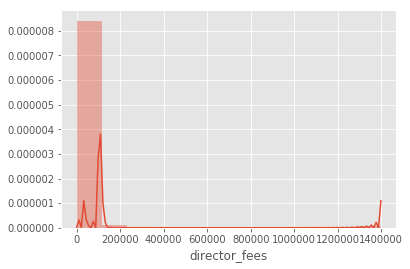

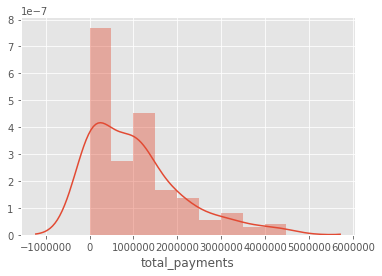

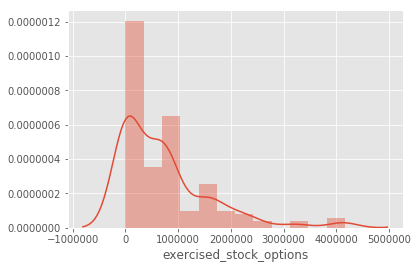

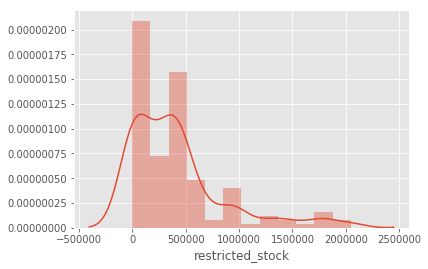

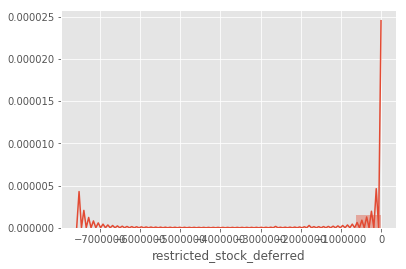

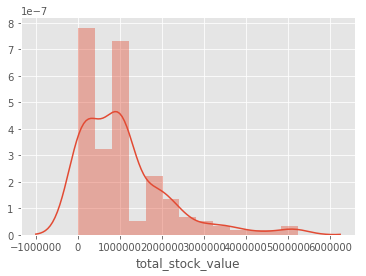

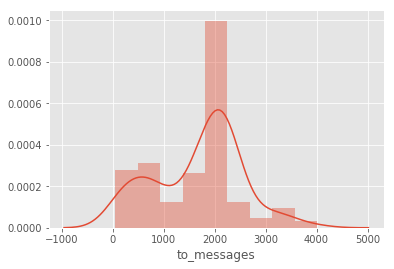

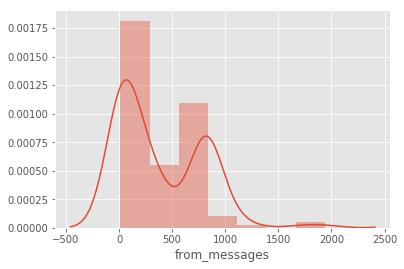

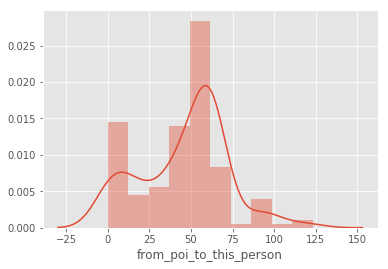

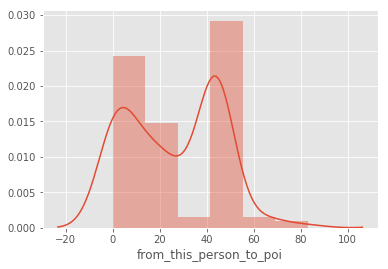

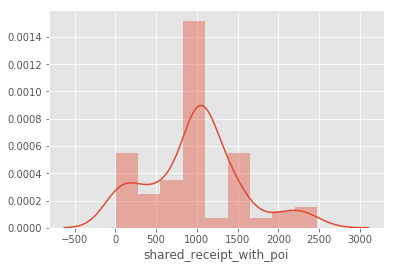

<Figure size 432x288 with 0 Axes>

In [18]:
# 檢視這些欄位的散佈範圍
for dtype, col in zip(df_data.dtypes, df_data.ix[:, 1:].columns):
    if dtype == 'float64':
        sns.distplot(df_data[col])
        plt.figure()
        #g = sns.FacetGrid(df_data[col])        
        #g.map(sns.distplot, col, kde = False)
        #x = np.arange(1, len(df_data[col])+1)   
        #plt.scatter(x, df_data[col])
        #plt.suptitle(col)
        #plt.show()   

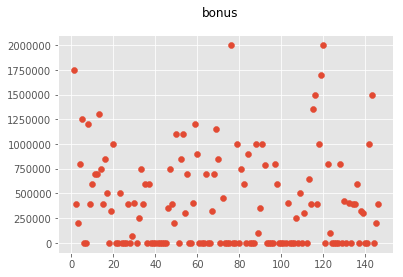

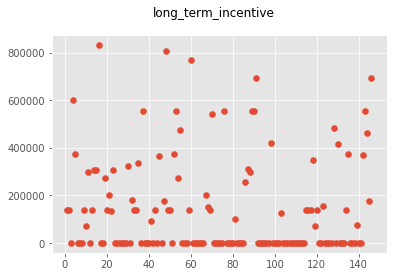

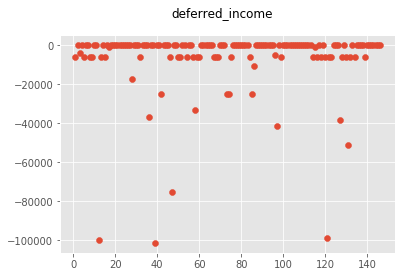

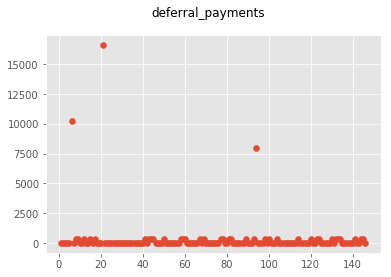

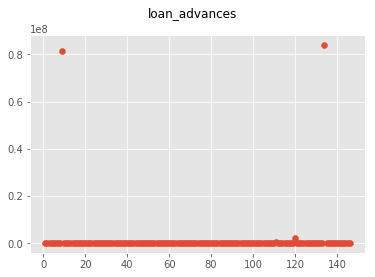

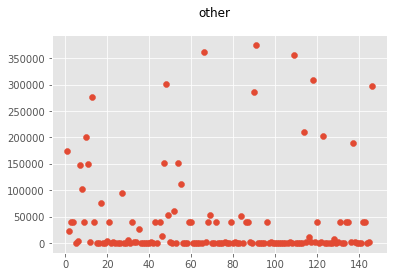

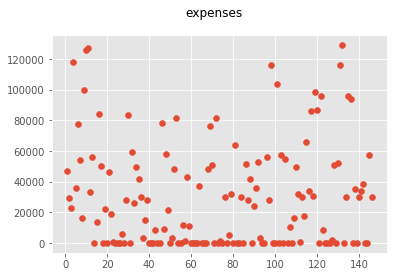

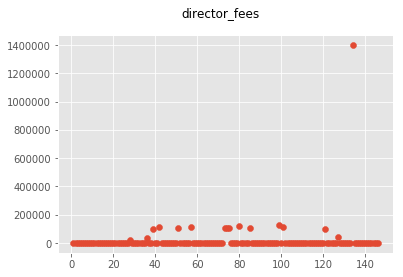

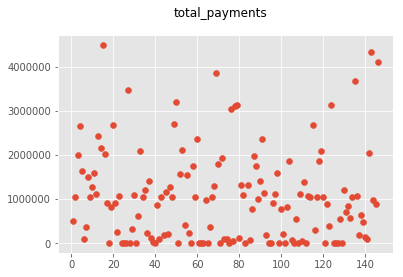

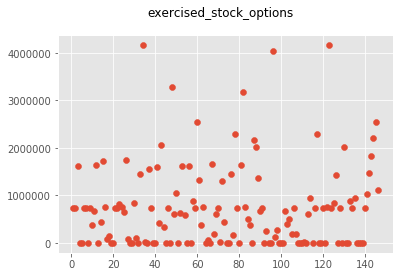

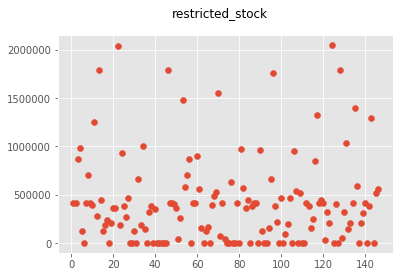

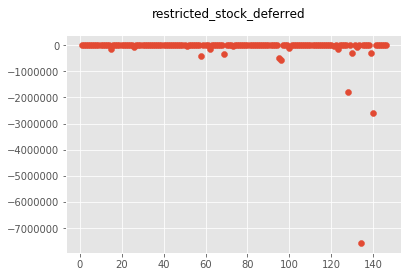

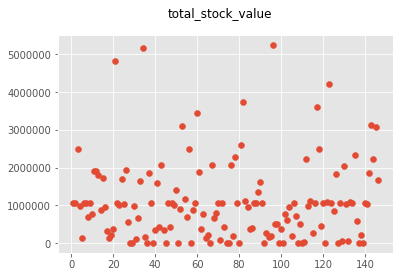

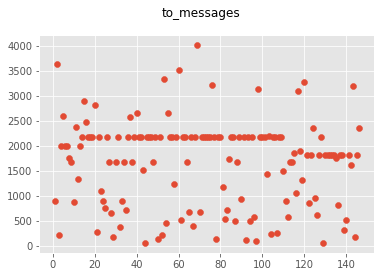

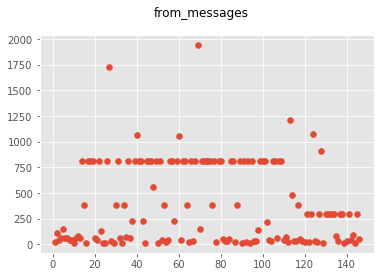

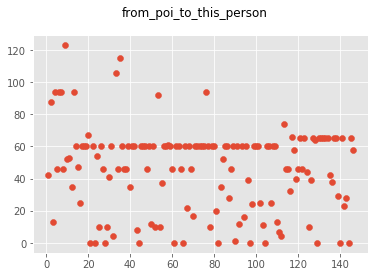

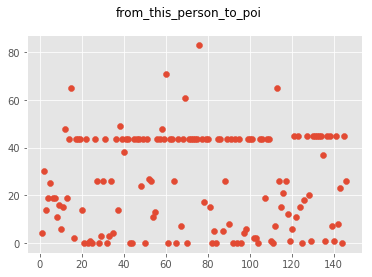

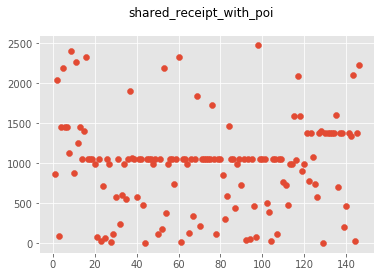

In [19]:
# 檢視這些欄位的散佈範圍
for dtype, col in zip(df_data.dtypes, df_data.ix[:, 1:].columns):
    if dtype == 'float64':
        x = np.arange(1, len(df_data[col])+1)   
        plt.scatter(x, df_data[col])
        plt.suptitle(col)
        plt.show()   

In [20]:
len(df_data)

146

In [21]:
# Find the number of poi and non poi now in the data
df_data['poi'].value_counts()

False    100
True      13
Name: poi, dtype: int64

In [22]:
# test data do not have poi columns
print(f"Persons of interest in test data：{len(df_data[df_data['poi'].isnull() == True]['poi'])}")

Persons of interest in test data：33


In [23]:
print(f'{f"0 value percentage : %.2f" % ((df_data[df_data == 0].count().sum() / df_data.count().sum())* 100)} %')
print(f'{f"Persons of interest percentage : %.2f" % ((13 / 113)* 100)} %')

0 value percentage : 40.01 %
Persons of interest percentage : 11.50 %


In [24]:
# 秀出資料欄位的類型與數量
dtype_df = df_data.dtypes.reset_index()
dtype_df.columns = ["Count", "ColumnType"]
dtype_df = dtype_df.groupby("ColumnType").aggregate('count').reset_index()
print(dtype_df.head())

  ColumnType  Count
0    float64     19
1     object      1


【__Precision and Recall__】
* __Precision__ is the number of correct positive classifications divided by the total number of positive labels assigned.

$$ precision = \frac{true\ positives}{true\ positives + false\ positives} $$

* __Recall__ is the number of correct positive classifications divided by the number of positive instances that should have been identified.

\\[ recall = \frac{true\ positives}{true\ positives + false\ negatives} \\]

Precision is also known as positive predictive value while recall is called the sensitivity of the classifier.

* __ F1 score__ is a combined measured of precision and recall. Is it the harmonic mean of precision and recall. Mathematically, the F1 score is defined as:

\\[ F1\ Score = \frac{2\ (precision\ x\ recall)}{precision + recall} \\]
<img src="https://idalab.de/wp-content/uploads/PRandhPR_diagram.jpg", width = "50%" >

In [25]:
# Convert ['poi'] (Person-of-Interest, poi)
df_data['poi'] = df_data['poi'].map({True:1, False:0})

In [26]:
train_target = np.array(df_data.loc[(df_data['poi'].isnull() == False), 'poi'].astype('int')).flatten()
train_data = df_data.ix[:len(df_train), 1:]
test_submit = df_data.ix[len(df_train):, 1:]
test_names = df_data[len(df_train):].index

In [27]:
std = StandardScaler()
X_std = std.fit_transform(train_data)
mms = MinMaxScaler()
X_mms = mms.fit_transform(train_data)
norm = Normalizer()
X_norm = norm.fit_transform(train_data)

In [28]:
from sklearn.linear_model import LogisticRegression
''' LogisticRegression(C = 0.0001, class_weight = None, dual = False,
          fit_intercept = True, intercept_scaling = 1, max_iter = 100,
          multi_class = 'ovr', n_jobs = 1, penalty = 'l2', random_state = None,
          solver = 'liblinear', tol = 0.0001, verbose = 0, warm_start = False) '''

# Model complexity
C = np.arange(0.0001, 0.5, 0.0002)
kfold = 10
val_accuracy = {'std':[], 'mms':[], 'norm':[]}
bestlog_reg = None
bestAcc = 0.0
bestScaling = None
# Loop over different values of c
for i, c in enumerate(C):
    log_reg = LogisticRegression(C = c, class_weight = 'balanced', penalty = 'l2')
    # validation accuracy
    s1 = np.mean(cross_val_score(log_reg, X_std, train_target, cv = kfold))
    val_accuracy['std'].append(s1)
    s2 = np.mean(cross_val_score(log_reg, X_mms, train_target, cv = kfold))
    val_accuracy['mms'].append(s2)
    s3 = np.mean(cross_val_score(log_reg, X_norm, train_target, cv = kfold))
    val_accuracy['norm'].append(s3)
    if s1 > bestAcc:
        bestAcc = s1
        bestlog_reg = log_reg
        bestScaling = 'std'
    elif s2 > bestAcc:
        bestAcc = s2
        bestlog_reg = log_reg
        bestScaling = 'mms'
    elif s3 > bestAcc:
        bestAcc = s3
        bestlog_reg = log_reg
        bestScaling = 'norm'

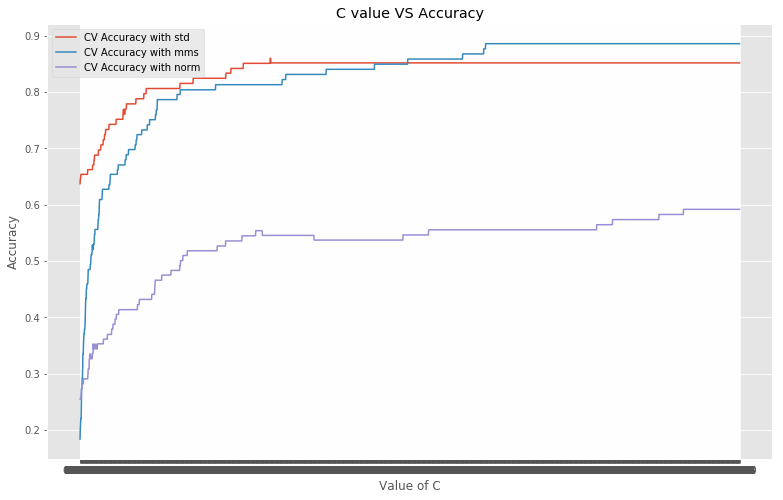

Best Accuracy with feature scaling : 0.8856060606060605
Best log_reg classifier : LogisticRegression(C=0.30750000000000005, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best scaling : mms


In [29]:
# Plot
plt.figure(figsize = [13,8])
plt.plot(C, val_accuracy['std'], label = 'CV Accuracy with std')
plt.plot(C, val_accuracy['mms'], label = 'CV Accuracy with mms')
plt.plot(C, val_accuracy['norm'], label = 'CV Accuracy with norm')
plt.legend()
plt.title('C value VS Accuracy')
plt.xlabel('Value of C')
plt.ylabel('Accuracy')
plt.xticks(C)
plt.show()

print('Best Accuracy with feature scaling :', bestAcc)
print('Best log_reg classifier :', bestlog_reg)
print('Best scaling :', bestScaling)

In [30]:
# Make the model with the specified regularization parameter
y_pred_mms = mms.transform(test_submit)

log_reg = LogisticRegression(C = 0.30750000000000005, class_weight = 'balanced', penalty = 'l2')
log_reg.fit(X_mms, train_target)
y_pred_proba = log_reg.predict_proba(y_pred_mms)[:, 1]
print(f'score : {cross_val_score(log_reg, X_mms, train_target, cv = 10).mean()}')

score : 0.8856060606060605


In [31]:
# predict test submit
submission = pd.DataFrame(y_pred_proba)
submission.columns = ['poi']
submission['name'] = test_names
submission = submission.ix[:,['name', 'poi']]
print(submission.shape)
submission.to_csv(f'{data_path}submit_pred_log_reg_C2.csv', index = False)
submission.head()

(33, 2)


,name,poi
0,BELDEN TIMOTHY N,0.442465
1,BOWEN JR RAYMOND M,0.671505
2,HANNON KEVIN P,0.562498
3,DELAINEY DAVID W,0.669378
4,CAUSEY RICHARD A,0.709639


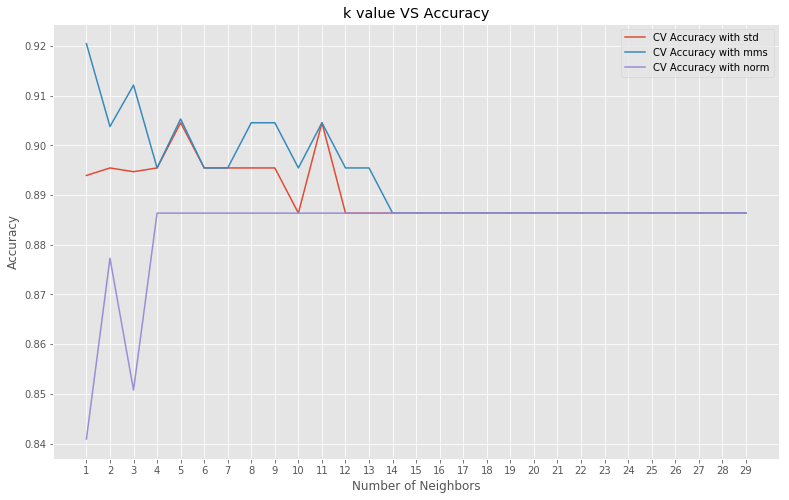

Best Accuracy with feature scaling : 0.9121212121212121
Best kNN classifier : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
Best scaling : mms


In [32]:
from sklearn.neighbors import KNeighborsClassifier

# Model complexity
neig = np.arange(1, 30)
kfold = 10
val_accuracy = {'std':[], 'mms':[], 'norm':[]}
bestKnn = None
bestAcc = 0.0
bestScaling = None
# Loop over different values of k
for i, k in enumerate(neig):
    knn = KNeighborsClassifier(n_neighbors = k)
    # validation accuracy
    s1 = np.mean(cross_val_score(knn, X_std, train_target, cv = kfold))
    val_accuracy['std'].append(s1)
    s2 = np.mean(cross_val_score(knn, X_mms, train_target, cv = kfold))
    val_accuracy['mms'].append(s2)
    s3 = np.mean(cross_val_score(knn, X_norm, train_target, cv = kfold))
    val_accuracy['norm'].append(s3)
    if s1 > bestAcc:
        bestAcc = s1
        bestKnn = knn
        bestScaling = 'std'
    elif s2 > bestAcc:
        bestAcc = s2
        bestKnn = knn
        bestScaling = 'mms'
    elif s3 > bestAcc:
        bestAcc = s3
        bestKnn = knn
        bestScaling = 'norm'
        
# Plot
plt.figure(figsize = [13,8])
plt.plot(neig, val_accuracy['std'], label = 'CV Accuracy with std')
plt.plot(neig, val_accuracy['mms'], label = 'CV Accuracy with mms')
plt.plot(neig, val_accuracy['norm'], label = 'CV Accuracy with norm')
plt.legend()
plt.title('k value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.show()

print('Best Accuracy with feature scaling :', bestAcc)
print('Best kNN classifier :', bestKnn)
print('Best scaling :', bestScaling)

In [33]:
# Make the model with the specified regularization parameter
y_pred_mms = mms.transform(test_submit)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_mms, train_target)
y_pred_proba = knn.predict_proba(y_pred_mms)[:, 1]
print(f'score : {cross_val_score(knn, X_mms, train_target, cv = 10).mean()}')

score : 0.9121212121212121


In [34]:
# predict test submit
submission = pd.DataFrame(y_pred_proba)
submission.columns = ['poi']
submission['name'] = test_names
submission = submission.ix[:,['name', 'poi']]
print(submission.shape)
submission.to_csv(f'{data_path}submit_pred_knn_C2.csv', index = False)
submission.head()

(33, 2)


,name,poi
0,BELDEN TIMOTHY N,0.333333
1,BOWEN JR RAYMOND M,0.666667
2,HANNON KEVIN P,0.666667
3,DELAINEY DAVID W,0.333333
4,CAUSEY RICHARD A,0.666667


### Feature Engineering 

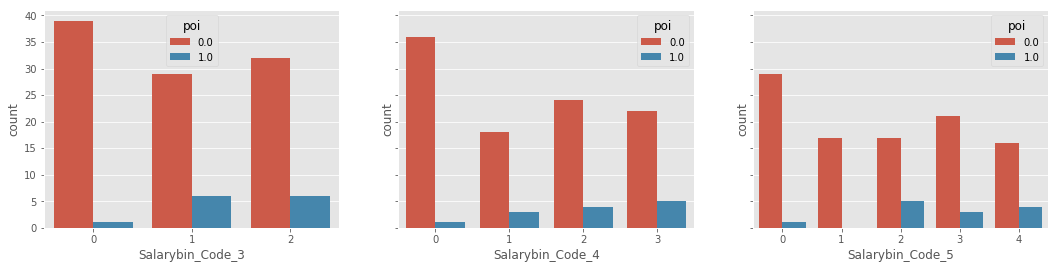

In [35]:
# Making Bins
df_data['Salarybin_3'] = pd.qcut(df_data['salary'].rank(method = 'first'), 3)
df_data['Salarybin_4'] = pd.qcut(df_data['salary'].rank(method = 'first'), 4)
df_data['Salarybin_5'] = pd.qcut(df_data['salary'].rank(method = 'first'), 5)

label = LabelEncoder()
df_data['Salarybin_Code_3'] = label.fit_transform(df_data['Salarybin_3'])
df_data['Salarybin_Code_4'] = label.fit_transform(df_data['Salarybin_4'])
df_data['Salarybin_Code_5'] = label.fit_transform(df_data['Salarybin_5'])

# plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey = True)
fig.set_figwidth(18)

sns.countplot(df_data['Salarybin_Code_3'], hue = df_data['poi'], ax = ax1 )
sns.countplot(df_data['Salarybin_Code_4'], hue = df_data['poi'], ax = ax2 )
sns.countplot(df_data['Salarybin_Code_5'], hue = df_data['poi'], ax = ax3 )

In [36]:
train_target = np.array(df_data.loc[(df_data['poi'].isnull() == False), 'poi'].astype('int')).flatten()
train_data = df_data.ix[:len(df_train), 1:]
test_submit = df_data.ix[len(df_train):, 1:]
test_names = df_data[len(df_train):].index

In [37]:
from sklearn.feature_selection import RFECV

compare = ['Salarybin_Code_3','Salarybin_Code_4','Salarybin_Code_5']
selector = RFECV(RandomForestClassifier(n_estimators = 100, min_samples_split = 20),cv = 10,n_jobs = -1)
selector.fit(train_data[compare], train_target)
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_ * 100)

[ True  True  True]
[1 1 1]
[88.63636364 88.63636364 88.63636364]


In [38]:
# Add the new salary features
features_list.append('Salarybin_Code_3')
#features_list.append('Salarybin_Code_4')
#features_list.append('Salarybin_Code_5')

In [39]:
# Add the new email features to the dataframe
df_data['to_poi_ratio'] = df_data['from_poi_to_this_person'] / df_data['to_messages']
df_data['from_poi_ratio'] = df_data['from_this_person_to_poi'] / df_data['from_messages']
df_data['shared_poi_ratio'] = df_data['shared_receipt_with_poi'] / df_data['to_messages']

In [40]:
# Create the new financial features and add to the dataframe
df_data['bonus_to_salary'] = df_data['bonus'] / df_data['salary']
df_data['bonus_to_total'] = df_data['bonus'] / df_data['total_payments']                  

In [41]:
 # Add the new email features
features_list.append('to_poi_ratio')
features_list.append('from_poi_ratio')
features_list.append('shared_poi_ratio')

# Add the new financial features
features_list.append('bonus_to_salary')
features_list.append('bonus_to_total')  

In [45]:
df_data = df_data[features_list]

# Fill any NaN financial data with a 0
df_data.ix[:, 1:].fillna(0, inplace = True)
#df_data.ix[:, 1:] = np.where(df_data.ix[:, 1:].isnull(), 0, df_data.ix[:, 1:])

In [46]:
# splits again beacuse we just engineered new feature
train_target = np.array(df_data.loc[(df_data['poi'].isnull() == False), 'poi'].astype('int')).flatten()
train_data = df_data.ix[:len(df_train), 1:]
test_submit = df_data.ix[len(df_train):, 1:]
test_names = df_data[len(df_train):].index

In [47]:
std = StandardScaler()
X_std = std.fit_transform(train_data)
mms = MinMaxScaler()
X_mms = mms.fit_transform(train_data)
norm = Normalizer()
X_norm = norm.fit_transform(train_data)

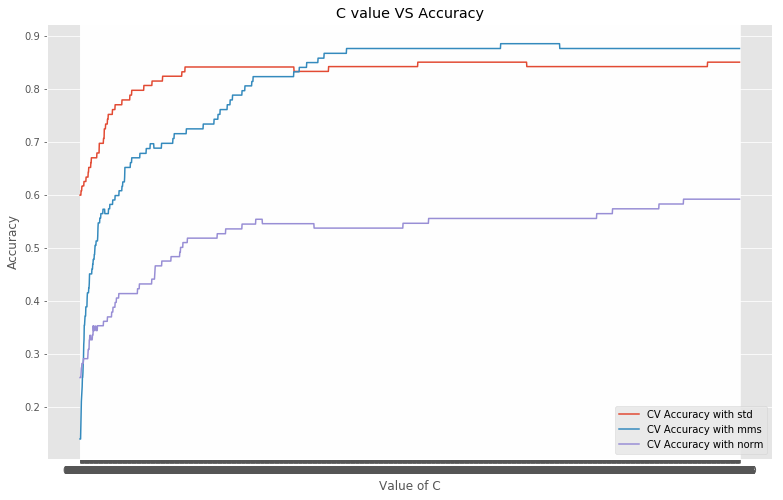

Best Accuracy with feature scaling : 0.884848484848485
Best log_reg classifier : LogisticRegression(C=0.3189000000000001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best scaling : mms


In [48]:
# Model complexity
C = np.arange(0.0001, 0.5, 0.0002)
kfold = 10
val_accuracy = {'std':[], 'mms':[], 'norm':[]}
bestlog_reg = None
bestAcc = 0.0
bestScaling = None
# Loop over different values of c
for i, c in enumerate(C):
    log_reg = LogisticRegression(C = c, class_weight = 'balanced', penalty = 'l2')
    # validation accuracy
    s1 = np.mean(cross_val_score(log_reg, X_std, train_target, cv = kfold))
    val_accuracy['std'].append(s1)
    s2 = np.mean(cross_val_score(log_reg, X_mms, train_target, cv = kfold))
    val_accuracy['mms'].append(s2)
    s3 = np.mean(cross_val_score(log_reg, X_norm, train_target, cv = kfold))
    val_accuracy['norm'].append(s3)
    if s1 > bestAcc:
        bestAcc = s1
        bestlog_reg = log_reg
        bestScaling = 'std'
    elif s2 > bestAcc:
        bestAcc = s2
        bestlog_reg = log_reg
        bestScaling = 'mms'
    elif s3 > bestAcc:
        bestAcc = s3
        bestlog_reg = log_reg
        bestScaling = 'norm'

# Plot
plt.figure(figsize = [13, 8])
plt.plot(C, val_accuracy['std'], label = 'CV Accuracy with std')
plt.plot(C, val_accuracy['mms'], label = 'CV Accuracy with mms')
plt.plot(C, val_accuracy['norm'], label = 'CV Accuracy with norm')
plt.legend()
plt.title('C value VS Accuracy')
plt.xlabel('Value of C')
plt.ylabel('Accuracy')
plt.xticks(C)
plt.show()

print('Best Accuracy with feature scaling :', bestAcc)
print('Best log_reg classifier :', bestlog_reg)
print('Best scaling :', bestScaling)

In [56]:
# Make the model with the specified regularization parameter
y_pred_mms = mms.transform(test_submit)

log_reg = LogisticRegression(C = 0.3189000000000001, class_weight = 'balanced', penalty = 'l2')
log_reg.fit(X_mms, train_target)
y_pred_proba = log_reg.predict_proba(y_pred_mms)[:, 1]
print(f'score : {cross_val_score(log_reg, X_mms, train_target, cv = 10).mean()}')

score : 0.884848484848485


In [57]:
# predict test submit
submission = pd.DataFrame(y_pred_proba)
submission.columns = ['poi']
submission['name'] = test_names
submission = submission.ix[:,['name', 'poi']]
print(submission.shape)
submission.to_csv(f'{data_path}submit_pred_log_reg_C3.csv', index = False)
submission.head()

(33, 2)


,name,poi
0,BELDEN TIMOTHY N,0.407199
1,BOWEN JR RAYMOND M,0.768851
2,HANNON KEVIN P,0.812690
3,DELAINEY DAVID W,0.594270
4,CAUSEY RICHARD A,0.706212


In [58]:
# 找出最適的超參數組合
n_estimators = [50, 100, 150, 400, 700]
max_depth = [1, 5, 10, 15, 20]
min_samples_split = [2, 3, 4, 10]
min_samples_leaf = [1, 5, 10]
#param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split,
 #                 min_samples_leaf = min_samples_leaf)

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf)
    
rfc = RandomForestClassifier()

# 建立搜尋物件，放入模型及參數組合字典 (n_jobs = -1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(rfc, param_grid, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = 5)

# 開始搜尋最佳參數
grid_result = grid_search.fit(train_data, train_target)

# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# print("All Results: %f using %d" % grid_result.grid_scores_)

Best Accuracy: -0.061947 using {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


In [59]:
x_train, x_test, y_train, y_test = train_test_split(train_data, train_target, test_size = 0.25, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 50, max_depth = 15, min_samples_split = 3, min_samples_leaf = 1, oob_score = True)
rfc.fit(train_data, train_target)
y_pred = rfc.predict(x_test)
y_pred_proba = rfc.predict_proba(test_submit)[:, 1]

print(f'Accuracy = {accuracy_score(y_test, y_pred):.3f}') # 查看準確率
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred)) # 預測值與實際值的差距，使用 MSE

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

# Observed oob score
print('Model RFC obb score : %.4f' % (rfc.oob_score_))

Accuracy = 1.000
Mean squared error: 0.00
Variance score: 1.00
Model RFC obb score : 0.9204


In [60]:
# predict test submit
submission = pd.DataFrame(y_pred_proba)
submission.columns = ['poi']
submission['name'] = test_names
submission = submission.ix[:,['name', 'poi']]
print(submission.shape)
submission.to_csv(f'{data_path}submit_pred_rfc_C7.csv', index = False)
submission.head()

(33, 2)


,name,poi
0,BELDEN TIMOTHY N,0.000000
1,BOWEN JR RAYMOND M,0.520000
2,HANNON KEVIN P,0.646667
3,DELAINEY DAVID W,0.106667
4,CAUSEY RICHARD A,0.426667


In [61]:
from sklearn import linear_model

# Lasso
L1_reg = linear_model.Lasso(alpha = 0.1) # 使用的 alpha 值越大，越少的特徵會被選擇
L1_reg.fit(train_data, train_target)
y_pred = L1_reg.predict(x_test)

coef_result = pd.DataFrame(train_data.columns, L1_reg.coef_)
print(f"Coefficients: \n{coef_result}") # 印出訓練後的模型參數，可以看到有些係數都變成 0，Lasso Regression 的確可以做特徵選取
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
                                       0
-1.427483e-07                     salary
 8.137655e-08                      bonus
-5.480787e-07        long_term_incentive
-1.972053e-06            deferred_income
 1.770716e-05          deferral_payments
 6.665166e-10              loan_advances
 8.848390e-07                      other
 1.379243e-06                   expenses
-3.803153e-07              director_fees
 1.858673e-08             total_payments
 1.106649e-08    exercised_stock_options
 6.951958e-08           restricted_stock
 3.535724e-07  restricted_stock_deferred
-2.669528e-08          total_stock_value
-6.415232e-05                to_messages
-3.293756e-04              from_messages
 1.815753e-03    from_poi_to_this_person
 0.000000e+00    from_this_person_to_poi
 2.990424e-04    shared_receipt_with_poi
-0.000000e+00           Salarybin_Code_3
-0.000000e+00               to_poi_ratio
 0.000000e+00             from_poi_ratio
-0.000000e+00           shared_poi_ratio
-

In [62]:
# Ridge
L2_reg = linear_model.Ridge (alpha = 0.1)
L2_reg.fit(train_data, train_target)
y_pred = L2_reg.predict(x_test)

print('Coefficients: ', L2_reg.coef_) # 印出訓練後的模型參數
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients:  [-8.31362061e-10  1.87178453e-07 -4.86361930e-07 -1.88640981e-06
  1.18824946e-05 -4.21721974e-10  6.25660913e-07  1.38239801e-06
 -4.19032555e-07  1.85317643e-08  7.38431400e-09  3.06777757e-08
  1.67229467e-07 -1.44469128e-08 -1.66440023e-04 -1.58778728e-04
  3.23329068e-03 -2.60958955e-03  4.72432948e-04 -2.74731179e-02
 -2.02125293e-01  6.96059467e-01 -4.67401411e-01 -4.91855885e-02
  1.10033506e-01]
Mean squared error: 0.04
Variance score: 0.73


In [ ]:
# Get the feature importances of the DecisionTree Classifier
rfc_features = pd.Series(data = rfc.feature_importances_, index = df_data.ix[:, 1:].columns)
rfc_features = rfc_features.sort_values(ascending = False) 

# Display the feature names and importance values
print(f'Tree Feature Importances:\n{rfc_features}')
pd.DataFrame(np.hstack(rfc_features), columns = ['Wine_feature_names', 'Feature importance'])

### Feature Visualization 

In [ ]:
poi_df = df_data[df_data['poi'] == True]
nonpoi_df = df_data[df_data['poi'] == False]

plt.rcParams.update({'font.size':12})
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(121)
plt.scatter(x = poi_df['from_poi_ratio'], y = poi_df['to_poi_ratio'], color = 'red', marker='*')
plt.scatter(x = nonpoi_df['from_poi_ratio'], y = nonpoi_df['to_poi_ratio'], color = 'c')
plt.xlabel('From Poi Ratio'); 
plt.ylabel('To Poi Ratio'); 
plt.title('Email Ratios'); 
plt.legend(['poi', 'nonpoi'], prop = {'size': 16})

ax2 = fig.add_subplot(122)
plt.scatter(x = poi_df['bonus_to_salary'], y = poi_df['bonus_to_total'], color = 'red', marker='*')
plt.scatter(x = nonpoi_df['bonus_to_salary'], y = nonpoi_df['bonus_to_total'], color = 'c')
plt.xlabel('Bonus to Salary'); 
plt.ylabel('Bonus to Total'); 
plt.title('Bonus Ratios');
plt.legend(['poi', 'nonpoi'], prop = {'size': 16});

In [ ]:
from pandas.tools.plotting import scatter_matrix

plt.rcParams.update({'font.size':10})
features_to_plot = ['bonus',  'total_payments', 'to_poi_ratio', 'from_poi_ratio']
scatter_matrix(df_data[features_to_plot], figsize = (16, 8), c = df_data['poi']);
plt.suptitle('Scatter Matrix');

### Feature Selection 

In [ ]:
#correlation map
f,ax = plt.subplots(figsize = (10, 10))
sns.heatmap(pd.DataFrame(X_std).corr(), annot = True, linewidths =.5, fmt = '.1f', ax = ax)

In [ ]:
# split data train 70 % and val 30 %
X_train, X_val, y_train, y_val = train_test_split(X_std, train_target, test_size = 0.3, random_state = 42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state = 43)      
clr_rf = clf_rf.fit(X_train, y_train)

ac = accuracy_score(y_val,clf_rf.predict(X_val))
print('Accuracy is: ', ac)
cm = confusion_matrix(y_val, clf_rf.predict(X_val))
sns.heatmap(cm, annot = True, fmt = "d")

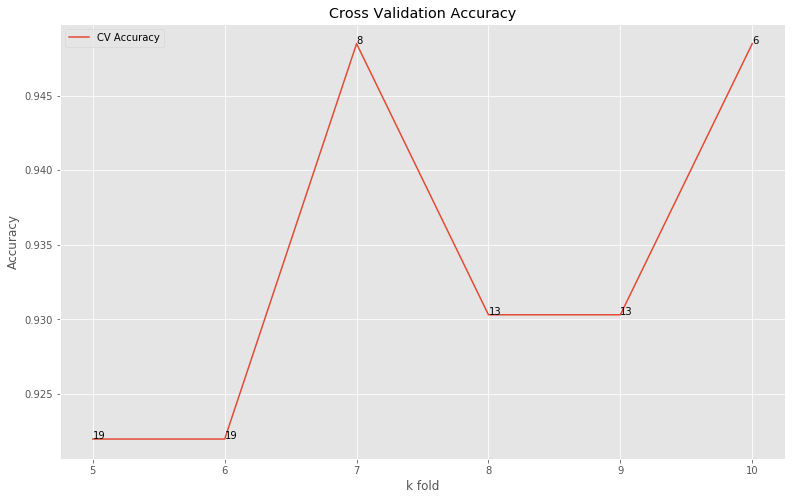

Best Accuracy with feature scaling and RFECV: 0.948484848485


In [157]:
from sklearn.svm import SVC

kfold = 10
bestSVC = None
bestAcc = 0.0
val_accuracy = []
cv_range = np.arange(5, 11)
n_feature = []
for cv in cv_range:
    # Create the RFE object and compute a cross-validated score.
    svc = SVC(kernel = "linear")
    # The "accuracy" scoring is proportional to the number of correct
    # classifications
    rfecv = RFECV(svc, step = 1, cv = cv, scoring = 'accuracy')
    rfecv.fit(X_std, train_target)

    # print("Optimal number of features : %d" % rfecv.n_features_)
    # print('Best features :', pd.DataFrame(X_train).columns[rfecv.support_])

    # Model complexity
    val_accuracy += [np.mean(cross_val_score(svc, X_std[:, rfecv.support_], train_target, cv = kfold))]
    n_feature.append(rfecv.n_features_)
    if val_accuracy[-1] > bestAcc:
        bestAcc = val_accuracy[-1]

# Plot
plt.figure(figsize=[13,8])
plt.plot(cv_range, val_accuracy, label = 'CV Accuracy')
for i in range(len(cv_range)):
    plt.annotate(str(n_feature[i]), xy=(cv_range[i], val_accuracy[i]))
plt.legend()
plt.title('Cross Validation Accuracy')
plt.xlabel('k fold')
plt.ylabel('Accuracy')
plt.show()

print('Best Accuracy with feature scaling and RFECV:', bestAcc)

In [159]:
# splits again beacuse we just engineered new feature
train_target = np.array(df_data.loc[(df_data['poi'].isnull() == False), 'poi'].astype('int')).flatten()
train_data = df_data.ix[:len(df_train), 1:]
test_submit = df_data.ix[len(df_train):, 1:]
test_names = df_data[len(df_train):].index

In [160]:
std = StandardScaler()
X_std = std.fit_transform(train_data)
mms = MinMaxScaler()
X_mms = mms.fit_transform(train_data)
norm = Normalizer()
X_norm = norm.fit_transform(train_data)

In [163]:
from sklearn.ensemble import VotingClassifier

x_train = train_data
y_train = train_target
x_test = test_submit
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_train = y_train.ravel()
print('training_x Shape:', x_train.shape,',training_y Shape:', y_train.shape, ',testing_x Shape:', x_test.shape)

training_x Shape: (113, 24) ,training_y Shape: (113,) ,testing_x Shape: (33, 24)


In [164]:
#Checking the models
x_all = np.r_[x_train,x_test]
print('x_all shape :',x_all.shape)

x_all shape : (146, 24)


In [175]:
#### USING THE GAUSSIAN MIXTURE MODEL ####
from sklearn.mixture import GaussianMixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        try:
            gmm = GaussianMixture(n_components = n_components, covariance_type = cv_type)
            gmm.fit(x_all)
            bic.append(gmm.aic(x_all))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
        except:
             break;
                 
best_gmm.fit(x_all)
x_train = best_gmm.predict_proba(x_train)
x_test = best_gmm.predict_proba(x_test)

ValueError: Expected the input data X have 24 features, but got 6 features

In [183]:
#### TAKING ONLY TWO MODELS FOR KEEPING IT SIMPLE ####
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

param_grid = dict( )
#### GRID SEARCH for BEST TUNING PARAMETERS FOR KNN #####
grid_search_knn = GridSearchCV(knn,param_grid=param_grid,cv=10,scoring='accuracy').fit(x_train,y_train)
print('best estimator KNN:',grid_search_knn.best_estimator_,'Best Score', grid_search_knn.best_estimator_.score(x_train,y_train))
knn_best = grid_search_knn.best_estimator_

#### GRID SEARCH for BEST TUNING PARAMETERS FOR RandomForest #####
grid_search_rf = GridSearchCV(rf, param_grid=dict( ), verbose=3,scoring='accuracy',cv=10).fit(x_train,y_train)
print('best estimator RandomForest:',grid_search_rf.best_estimator_,'Best Score', grid_search_rf.best_estimator_.score(x_train,y_train))
rf_best = grid_search_rf.best_estimator_


knn_best.fit(x_train,y_train)
print(knn_best.predict(x_test)[0:10])
rf_best.fit(x_train,y_train)
print(rf_best.predict(x_test)[0:10])

#### SCORING THE MODELS ####
print('Score for KNN :',cross_val_score(knn_best,x_train,y_train,cv=10,scoring='accuracy').mean())
print('Score for Random Forest :',cross_val_score(rf_best,x_train,y_train,cv=10,scoring='accuracy').max())

### IN CASE WE WERE USING MORE THAN ONE CLASSIFIERS THEN VOTING CLASSIFIER CAN BE USEFUL ###
#clf = VotingClassifier(
#		estimators=[('knn_best',knn_best),('rf_best', rf_best)],
#		#weights=[871856020222,0.907895269918]
#	)
#clf.fit(x_train,y_train)
#print clf.predict(x_test)[0:10]

##### FRAMING OUR SOLUTION #####
knn_best_pred = pd.DataFrame(knn_best.predict_proba(x_test)[:, 1])
rf_best_pred = pd.DataFrame(rf_best.predict_proba(x_test)[:, 1])
#voting_clf_pred = pd.DataFrame(clf.predict_proba(x_test))

knn_best_pred.index += 1
rf_best_pred.index += 1
#voting_clf_pred.index += 1

print(rf_best_pred)

best estimator KNN: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') Best Score 0.884955752212
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV] ....................... , score=0.8333333333333334, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.8333333333333334, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.8333333333333334, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.9090909090909091, total=   0.0s
[CV]  ................................................................
[CV] ....................... , score=0.9090909090909091, total=   0.0s
[CV]  .............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


0.902654867257
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Score for KNN : 0.877272727273
Score for Random Forest : 0.909090909091
           0
1   0.035135
2   0.206465
3   0.344921
4   0.000000
5   0.206465
6   0.206465
7   0.344921
8   0.000000
9   0.206465
10  0.000000
11  0.206465
12  0.000000
13  0.000000
14  0.000000
15  0.344921
16  0.000000
17  0.196667
18  0.344921
19  0.000000
20  0.000000
21  0.342619
22  0.206465
23  0.000000
24  0.000000
25  0.000000
26  0.196667
27  0.344921
28  0.000000
29  0.206465
30  0.206465
31  0.060000
32  0.000000
33  0.206465


In [184]:
# predict test submit
submission = pd.DataFrame(rf_best_pred)
submission.columns = ['poi']
submission['name'] = test_names
submission = submission.ix[:,['name', 'poi']]
print(submission.shape)
submission.to_csv(f'{data_path}submit_pred_rfc_C5.csv', index = False)
submission.head()

(33, 2)


,name,poi
1,BELDEN TIMOTHY N,0.035135
2,BOWEN JR RAYMOND M,0.206465
3,HANNON KEVIN P,0.344921
4,DELAINEY DAVID W,0.000000
5,CAUSEY RICHARD A,0.206465


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)
print(f'score : {cross_val_score(gbc, train_data, train_target, cv = 10).mean()}')
feats = pd.Series(data = gbc.feature_importances_, index = df_data.columns)
feats = feats.sort_values(ascending = False) 
feats

In [ ]:
from feature_format import featureFormat, targetFeatureSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

data_dict = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data_dict)

In [51]:
# Model complexity
C = np.arange(0.0001, 0.5, 0.0002)
kfold = 10
val_accuracy = {'std':[], 'mms':[], 'norm':[]}
bestlog_reg = None
bestAcc = 0.0
bestScaling = None
# Loop over different values of k
for i, c in enumerate(C):
    log_reg = LogisticRegression(C = c, class_weight = 'balanced', penalty = 'l2', random_state = 42)
    # validation accuracy
    s1 = np.mean(cross_val_score(log_reg, X_std, feature_Y, cv = kfold))
    val_accuracy['std'].append(s1)
    s2 = np.mean(cross_val_score(log_reg, X_mms, feature_Y, cv = kfold))
    val_accuracy['mms'].append(s2)
    s3 = np.mean(cross_val_score(log_reg, X_norm, feature_Y, cv = kfold))
    val_accuracy['norm'].append(s3)
    if s1 > bestAcc:
        bestAcc = s1
        bestlog_reg = log_reg
        bestScaling = 'std'
    elif s2 > bestAcc:
        bestAcc = s2
        bestlog_reg = log_reg
        bestScaling = 'mms'
    elif s3 > bestAcc:
        bestAcc = s3
        bestlog_reg = log_reg
        bestScaling = 'norm'

In [54]:
# Using GridSearchCV to tune and optimize
C = np.arange(0.01, 0.5, 0.01)
param_grid = dict(C = C)    
log_reg = LogisticRegression(class_weight = 'balanced', penalty = 'l2', random_state = 42 )

# 建立搜尋物件，放入模型及參數組合字典 (n_jobs = -1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(log_reg, param_grid, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = 5)

# 開始搜尋最佳參數
grid_result = grid_search.fit(train_X, train_Y)
    
# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# print("All Results: %f using %d" % grid_result.grid_scores_)

Best Accuracy: -0.183486 using {'C': 0.29999999999999999}


In [ ]:
# Add the new email features to the dataframe
df['to_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
df['from_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']
df['shared_poi_ratio'] = df['shared_receipt_with_poi'] / df['to_messages']

In [53]:
# gridplot = sns.pairplot(df) 對角線兩兩變數分布圖
# heatmap = sns.heatmap(matrix, cmap = plt.cm.RdYlBu_r, vmin = -1., vmax = 1., annot = True)


### Feature Scaling

In [25]:
feature_X = train_X
feature_Y = train_Y

std = StandardScaler()
X_std = std.fit_transform(feature_X)
mms = MinMaxScaler()
X_mms = mms.fit_transform(feature_X)
norm = Normalizer()
X_norm = norm.fit_transform(feature_X)

NameError: name 'train_X' is not defined

In [ ]:
# Plot
plt.figure(figsize = [13,8])
plt.plot(neig, val_accuracy['std'], label = 'CV Accuracy with std')
plt.plot(neig, val_accuracy['mms'], label = 'CV Accuracy with mms')
plt.plot(neig, val_accuracy['norm'], label = 'CV Accuracy with norm')
plt.legend()
plt.title('k value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.show()

print('Best Accuracy with feature scaling :', bestAcc)
print('Best kNN classifier :', bestKnn)
print('Best scaling :', bestScaling)

### Feature Selection

In [ ]:
# correlation map
f, ax = plt.subplots(figsize = (16, 8))
sns.heatmap(pd.DataFrame(feature_X).corr(), annot = True, linewidths = .5, fmt = '.1f',ax = ax)

In [ ]:
# split data train 70 % and val 30 %
X_train, X_val, y_train, y_val = train_test_split(train_X, y, test_size = 0.30, random_state = 42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state = 43)      
clr_rf = clf_rf.fit(X_train,y_train)

ac = accuracy_score(y_val,clf_rf.predict(X_val))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_val,clf_rf.predict(X_val))
sns.heatmap(cm,annot = True, fmt = "d")

In [22]:
from sklearn.preprocessing import scale
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
import tester

# Scale the dataset and send it back to a dictionary
scaled_df = df_data.copy()
scaled_df.ix[:,1:] = scale(scaled_df.ix[:,1:])
my_dataset = scaled_df.to_dict(orient='index')

# Create and test the Gaussian Naive Bayes Classifier
clf = GaussianNB()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

ModuleNotFoundError: No module named 'tester'

In [ ]:
# Create and test the Decision Tree Classifier
clf = DecisionTreeClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

C:\Users\10708055\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\10708055\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


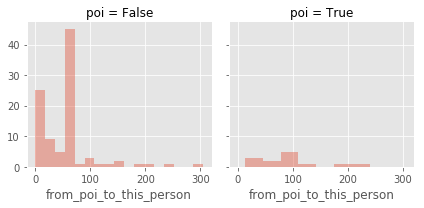

In [59]:
g = sns.FacetGrid(df_data, col = 'poi')
g.map(sns.distplot, 'from_poi_to_this_person', kde = False)

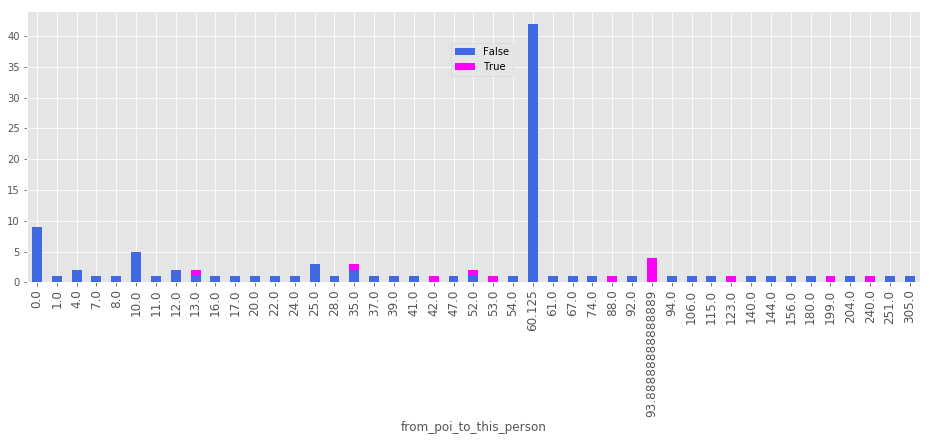

In [57]:
pd.crosstab(df_data.from_poi_to_this_person, df_data.poi).plot.bar(stacked = True, figsize = (16, 5), color = ['#4169E1','#FF00FF'])
plt.xticks(rotation = 90, size = 'large')
plt.legend(bbox_to_anchor = (0.55, 0.9))

In [58]:
TPP.plot(kind = 'bar',figsize = (16, 10))
plt.xticks(rotation = 40)
plt.axhline(0.8, color='#BA55D3')
plt.axhline(0.5, color='#BA55D3')
plt.annotate('80% survival rate',xy = (30,0.81),xytext = (32,0.85),arrowprops=dict(facecolor='#BA55D3',shrink=0.05))
plt.annotate('50% survival rate',xy = (32,0.51),xytext = (34,0.54),arrowprops=dict(facecolor='#BA55D3',shrink=0.05))

NameError: name 'TPP' is not defined

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

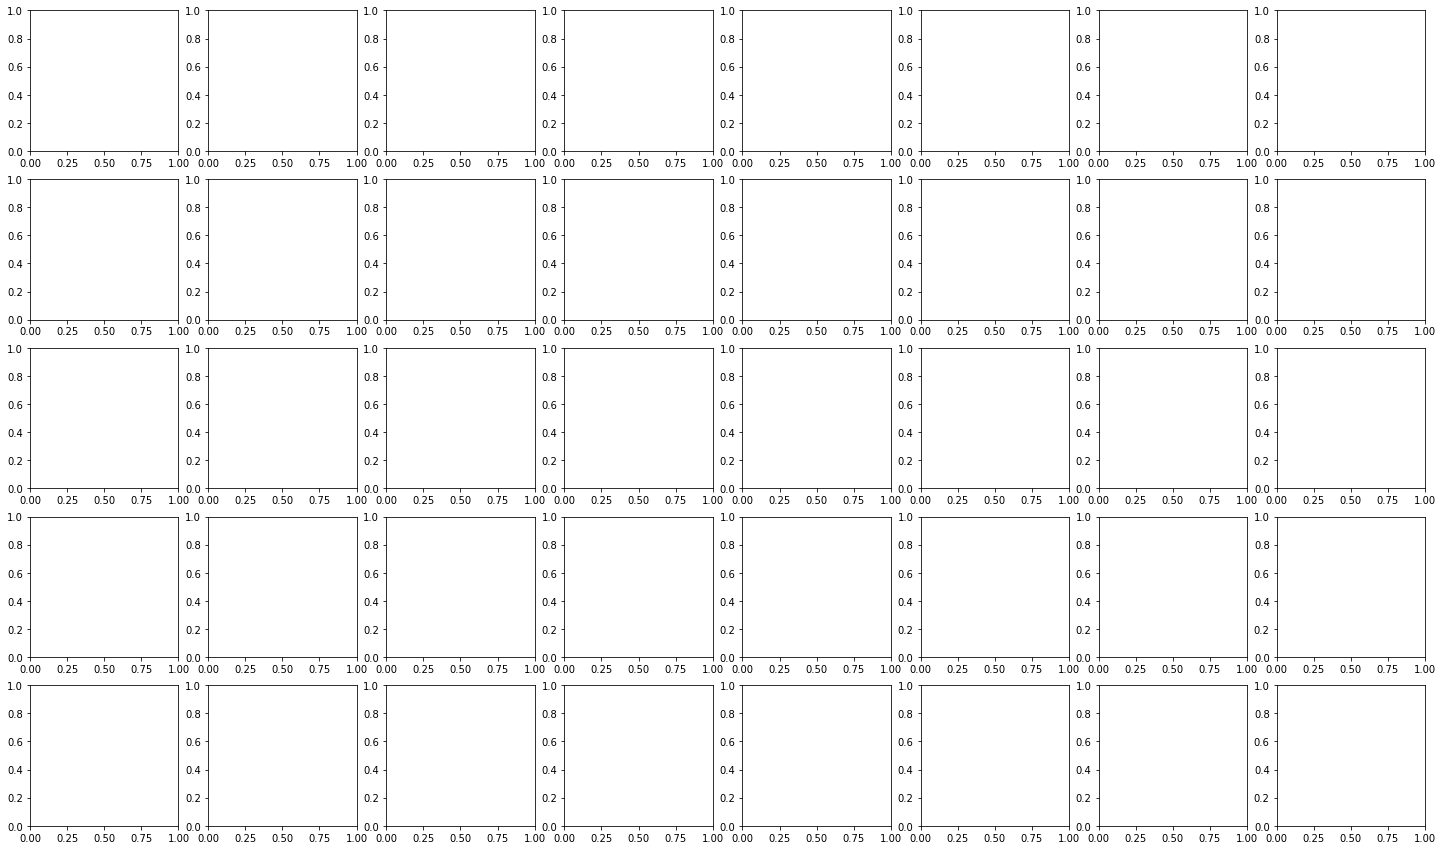

In [15]:
fig, axes = plt.subplots(5, 8, figsize = (25, 15))
poi =['1','0']

for i, ax in zip(poi, axes):
    for j, pp in zip(range(1, 9), ax):
        bonuspoi = df_data[(df_data.poi == i)&(df_data.bonus == j)]['poi'].value_counts().sort_index(ascending = False)
        pp.bar(range(len(bonuspoi)), bonuspoi, label = (i,'bonus' + str(j)))
        pp.set_xticks((0, 1))
        pp.set_xticklabels(('poi','Fraud'))
        pp.legend(bbox_to_anchor = (0.6,1.1))

In [ ]:
# predict test submit
RFC = RandomForestClassifier(n_estimators = 250, min_samples_split = 20, oob_score = True, random_state = 0)
RFC.fit(x_train, y_train)
submission = pd.DataFrame(RFC.predict(df[len(df_train):]).astype(int))
submission.columns = ['poi']
submission['name'] = names
print(submission.shape)
submission.to_csv(f'{data_path}submit_pred_rfc_C3.csv', index = False)